# Problem statement
Halloween is a night of costumes, fun, and candy that takes place every year on October 31. On this day people dress up in various costumes that have a scary overtone and go trick-or-treating to gather candy.

This year, on Halloween, there is a carnival in your neighborhood. Besides the various games, there are also 50 stalls that are selling various products, which fall under various categories.

Your task is to predict the selling price of the products based on the provided features. 

Data description  
The data folder consists of the following three .csv files:  

`train.csv`: (6368x15)  
`test.csv`: (3430x14)  
`submission.csv`: (5x2)

#### Importing necessary modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sweetviz as sv
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

# import warnings
# warnings.filterwarnings(action = 'ignore')

In [2]:
pd.set_option('display.max_rows', 1000)


In [3]:
submission = pd.read_csv('dataset/sample_submission.csv')
df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

In [4]:
# Analyzing the dataset with sweetviz
advert_report = sv.analyze(df,target_feat='Selling_Price')
# Display the report
advert_report.show_html('Carnival Wars.html')


Report Carnival Wars.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [5]:
df.isna().sum()

Product_id            0
Stall_no              5
instock_date          0
Market_Category       0
Customer_name       211
Loyalty_customer      0
Product_Category      0
Grade                 0
Demand                0
Discount_avail       38
charges_1           198
charges_2 (%)       205
Minimum_price        38
Maximum_price       343
Selling_Price        41
dtype: int64

In [6]:
df.drop('Customer_name', axis=1, inplace=True)
test_df.drop('Customer_name', axis=1, inplace=True)

In [7]:
is_NaN = df.isnull()
row_has_NaN = is_NaN. any(axis=1)
rows_with_NaN = df[row_has_NaN]
rows_with_NaN.head()

,Product_id,Stall_no,instock_date,Market_Category,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price
16,SHIEBKMSYJFA9XZT,14.0,2015-09-24 16:28:03.000,1,No,Fashion,0,74,0.0,NaN,11.0,786.0,NaN,2582.860500
33,BRAE8TFHWYCTDUM3,17.0,2015-08-19 21:08:45.000,101,No,Repair,0,19,0.0,NaN,9.0,950.0,1580.0,1563.983586
36,NKCE5T3GVHYKZSDH,5.0,2015-11-19 03:54:47.000,14,Yes,Child_care,0,61,0.0,323.0,14.0,5682.0,NaN,7056.729900
64,NKCECW7BSTZBHH6R,2.0,2015-09-24 17:26:11.000,268,Yes,Hospitality,2,28,NaN,340.0,9.0,945.0,2956.0,NaN
76,ACCEHZF95ZRCKACD,7.0,2015-05-09 17:19:45.000,358,Yes,Cosmetics,3,31,0.0,NaN,NaN,9483.0,13644.0,11761.213275


In [8]:
df.dropna(how='any', inplace=True)

In [9]:
test_df['charges_1'].fillna(test_df['charges_1'].median(), inplace=True)
test_df['charges_2 (%)'].fillna(test_df['charges_2 (%)'].median(), inplace=True)
test_df['Minimum_price'].fillna(test_df['Minimum_price'].median(), inplace=True)
test_df['Stall_no'].fillna(test_df['Stall_no'].median(), inplace=True)

In [10]:
df.Stall_no = df.Stall_no.astype(int)
test_df.Stall_no = test_df.Stall_no.astype(int)
df.Discount_avail = df.Discount_avail.astype(int)
test_df.Discount_avail = test_df.Discount_avail.astype(int)

df.Selling_Price = df.Selling_Price.apply(abs)

# df.dtypes

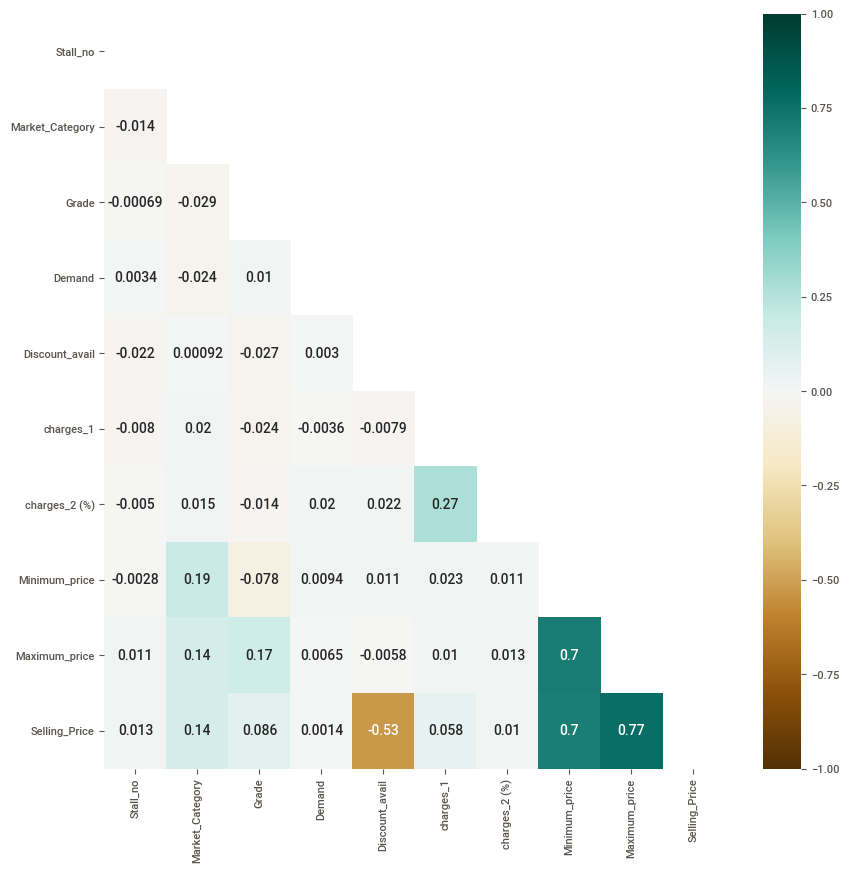

In [11]:
mask = np.triu(np.ones_like(df.corr()))
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(df.corr(), mask=mask,
                      vmin=-1, vmax=1, annot=True, cmap='BrBG')

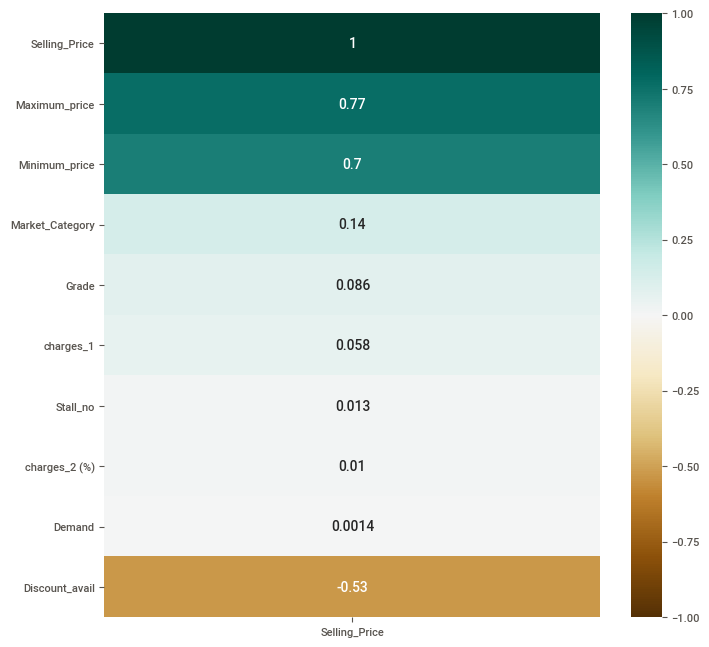

In [12]:
plt.figure(figsize=(8,8))
heatmap2 = sns.heatmap(df.corr()[['Selling_Price']].sort_values('Selling_Price',ascending=False),
                       vmin=-1, vmax=1, annot=True, cmap='BrBG')

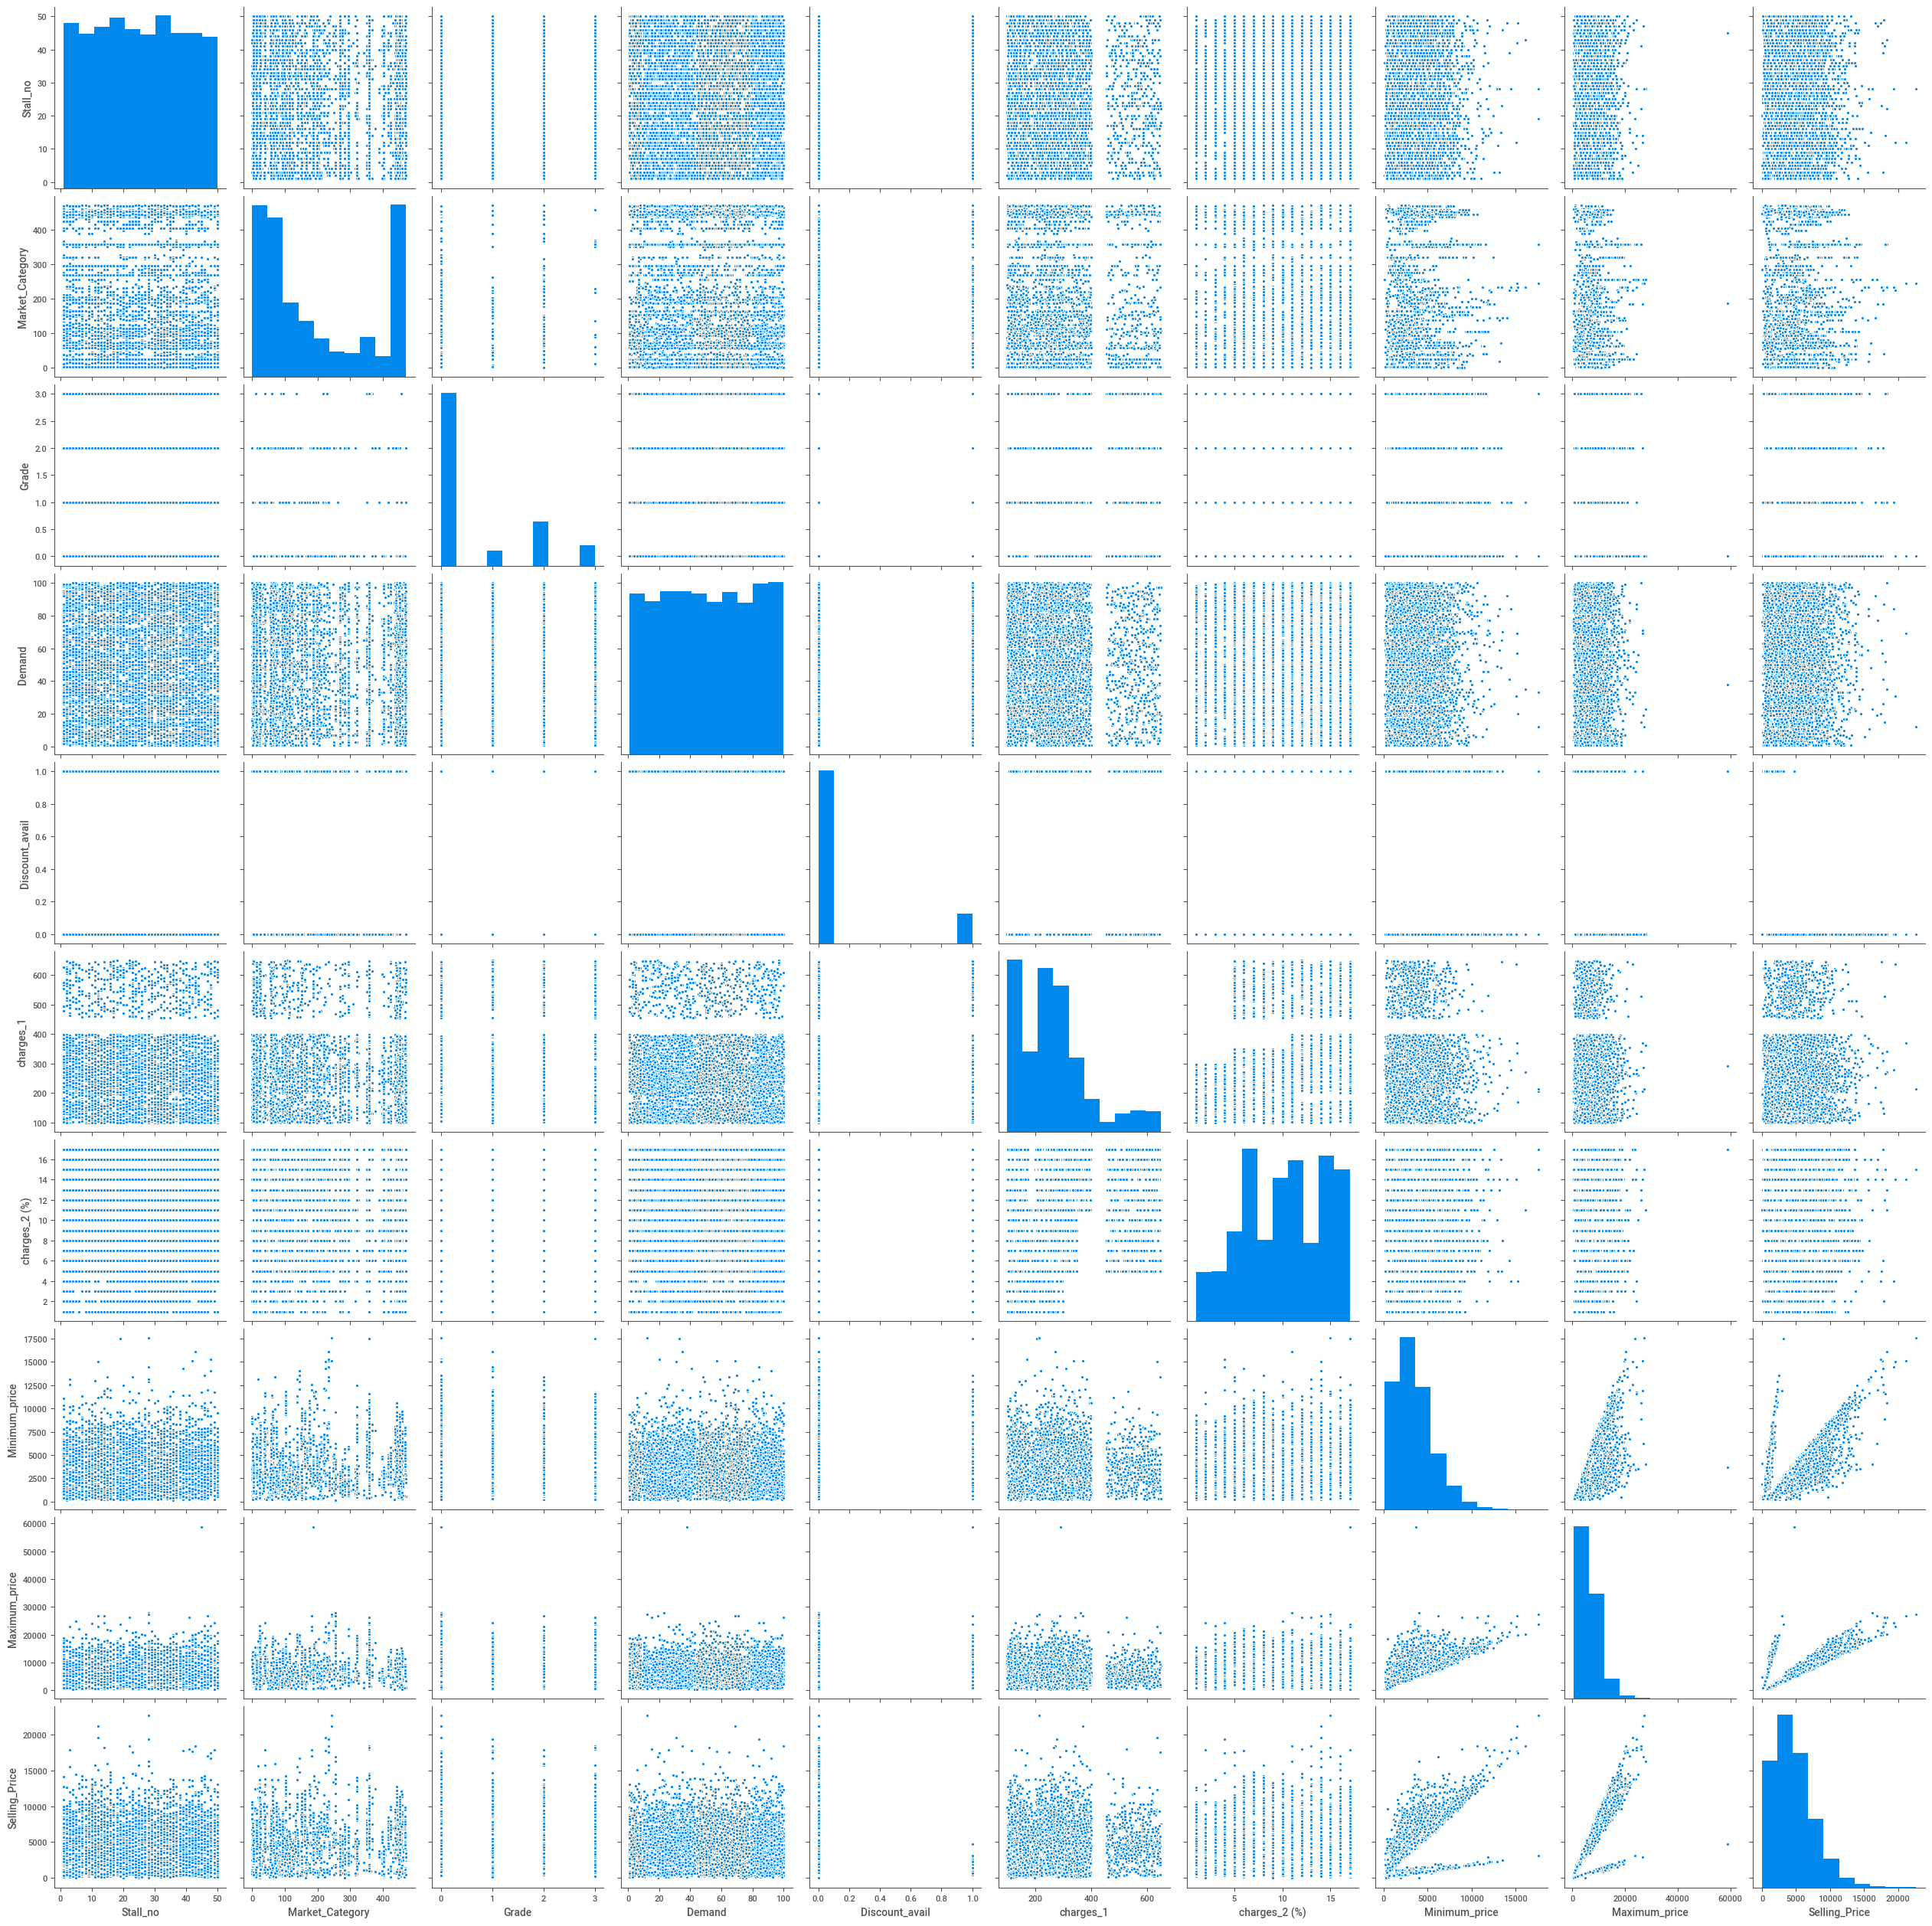

In [13]:
sns.pairplot(df)

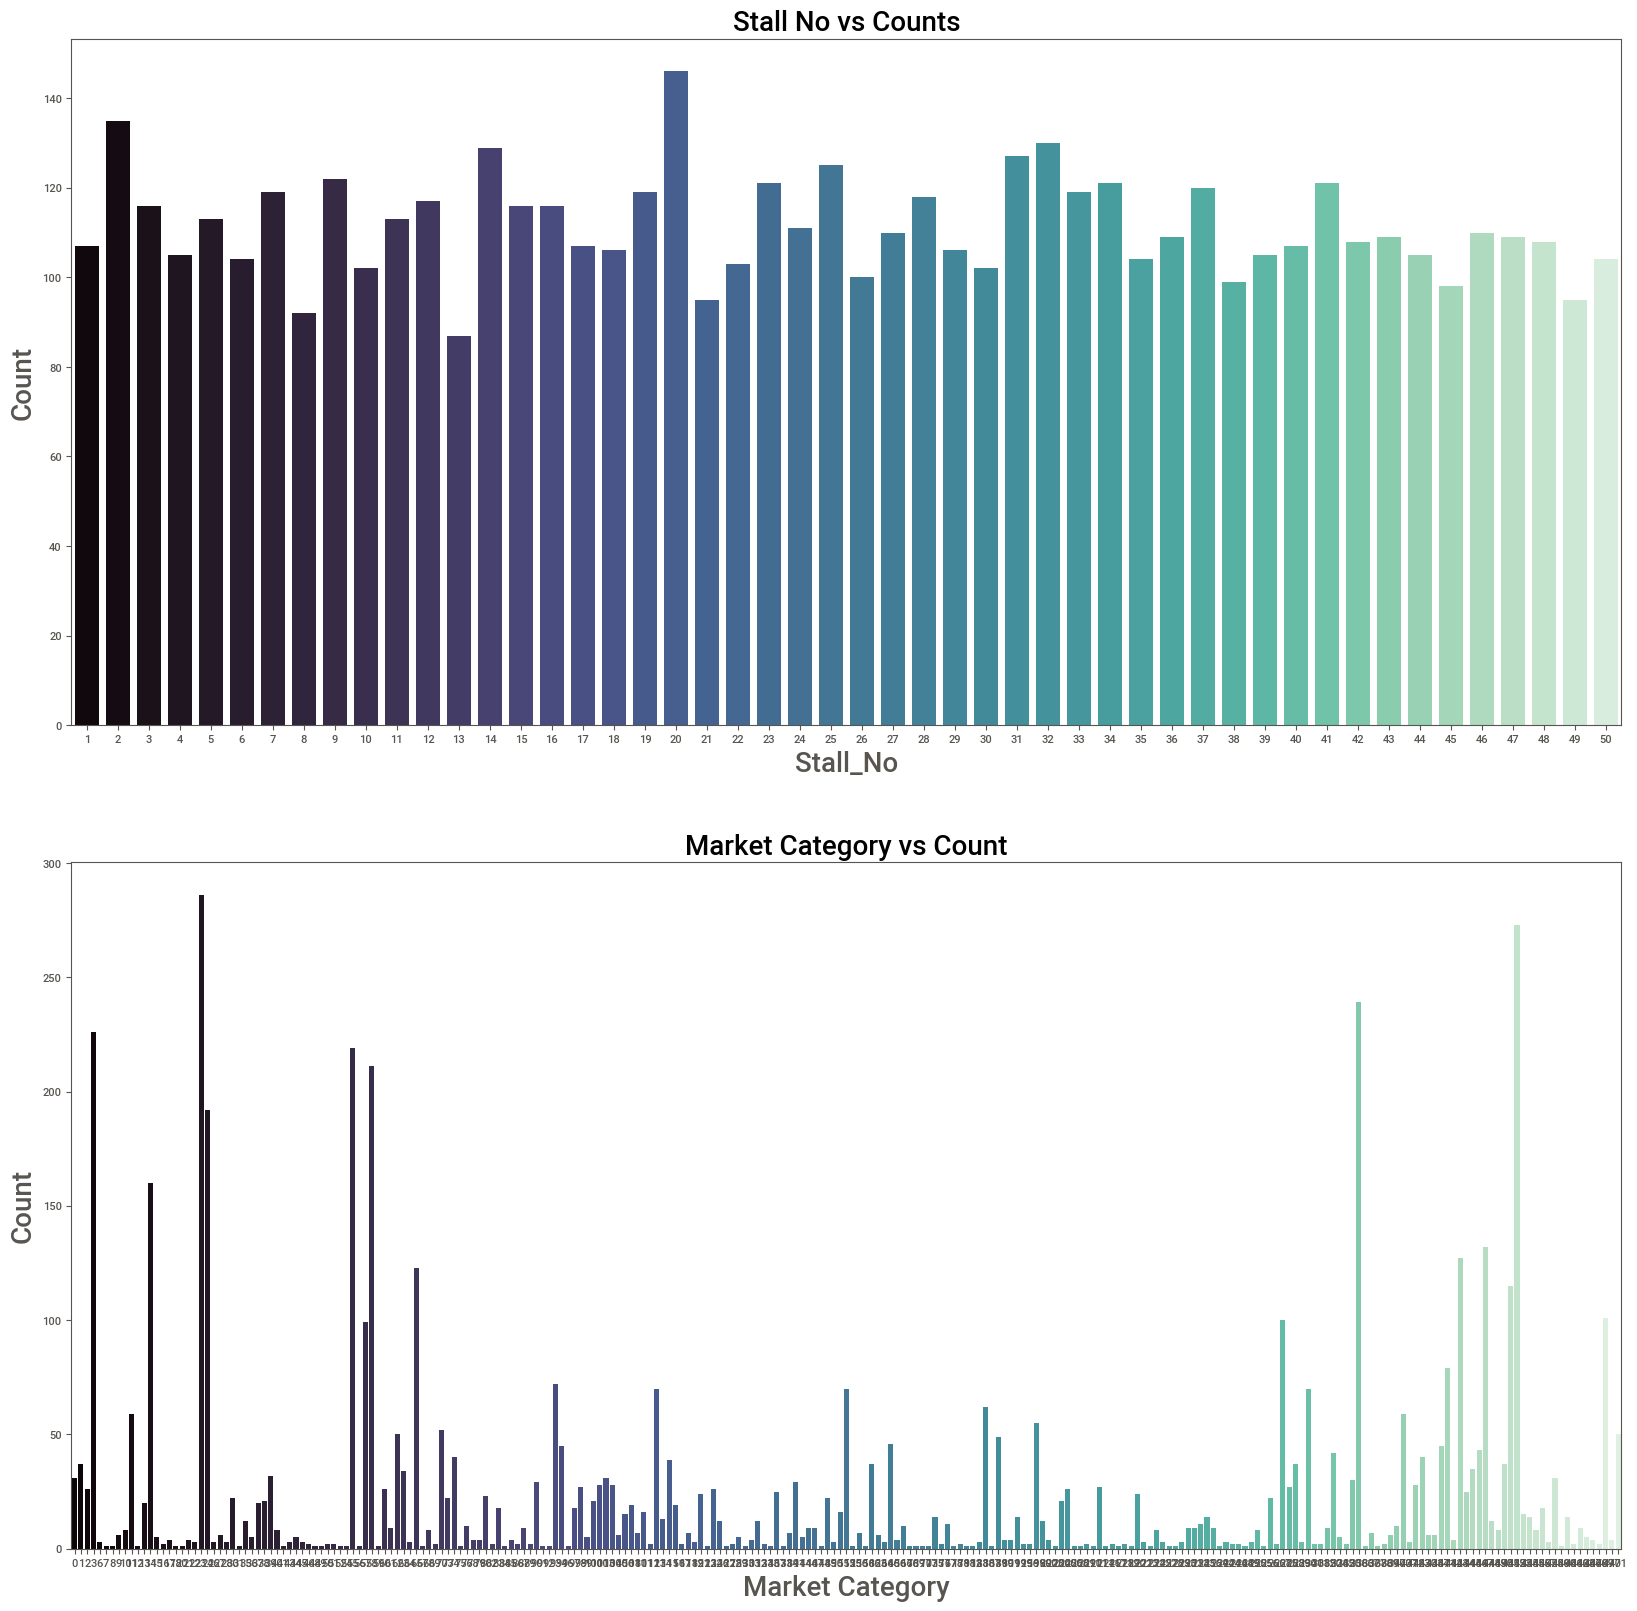

In [15]:
fig, axs = plt.subplots(2,1, figsize=(20,20))

sns.countplot(df.Stall_no, ax=axs[0], palette='mako')
axs[0].set_title('Stall No vs Counts', size=20)
axs[0].set_xlabel('Stall_No', size=20)
axs[0].set_ylabel('Count', size=20)


sns.countplot(df.Market_Category, ax=axs[1], palette='mako')
axs[1].set_title('Market Category vs Count', size=20)
axs[1].set_xlabel('Market Category', size=20)
axs[1].set_ylabel('Count', size=20)
plt.show()

Inferences from plot:  
`Stall_no` is uniformly spread out while `Market_Category` is not spread out uniformly

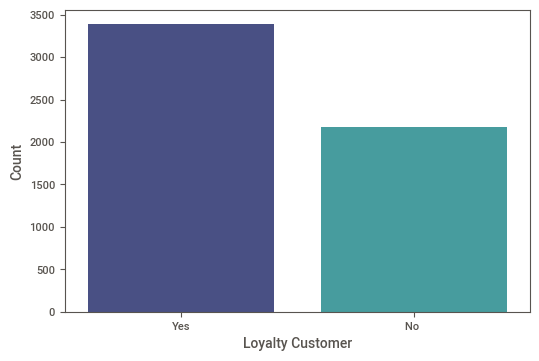

In [16]:
sns.countplot(df.Loyalty_customer, palette='mako')
plt.xlabel('Loyalty Customer')
plt.ylabel('Count')
plt.show()

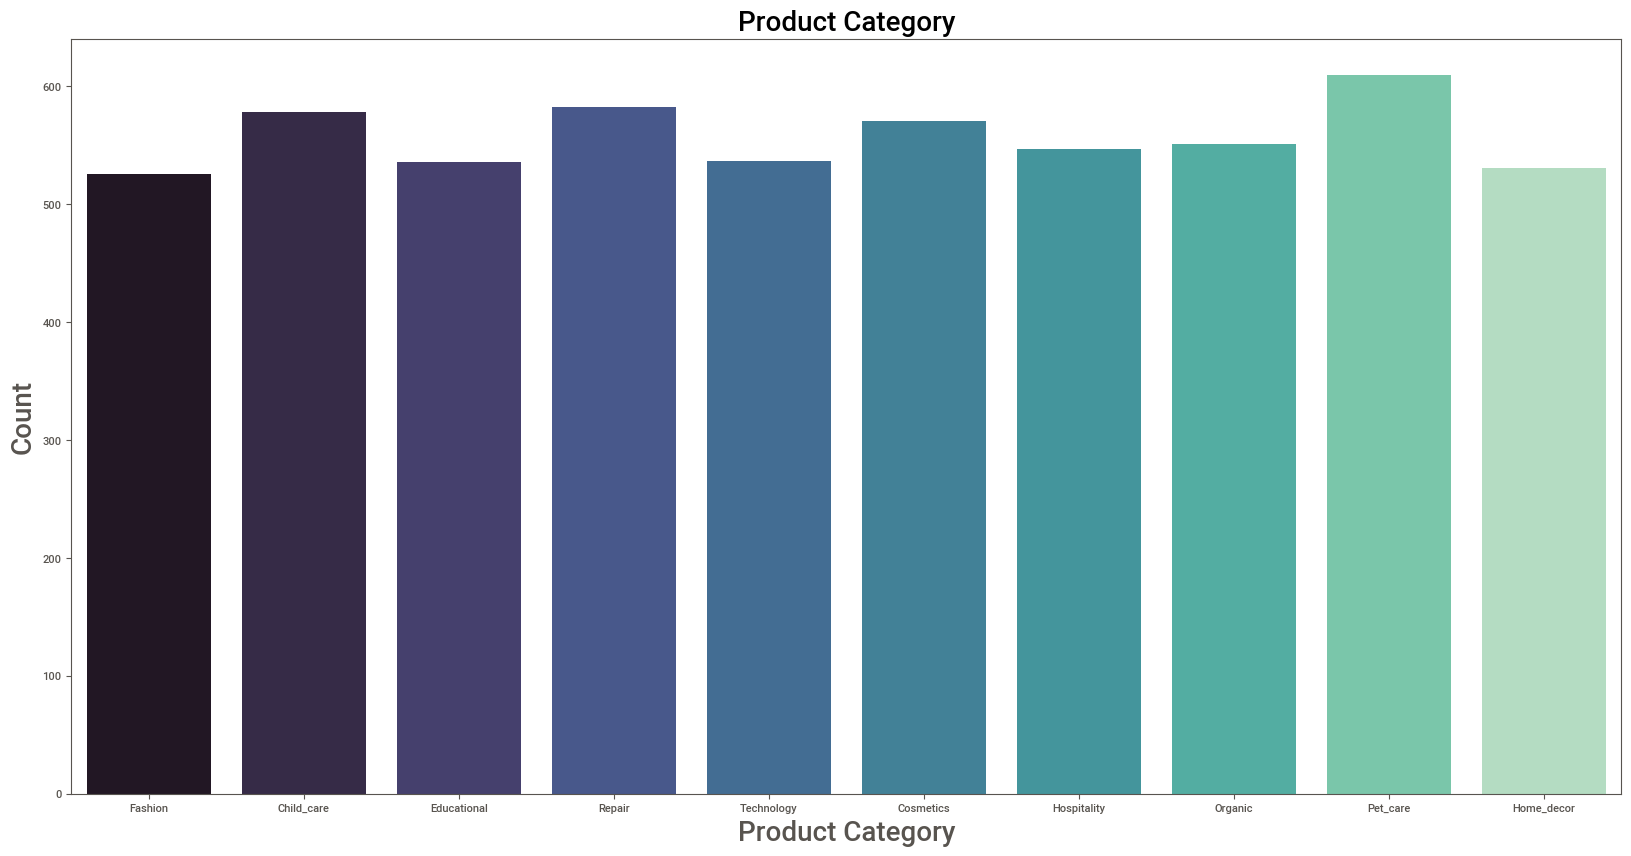

In [17]:
plt.figure(figsize=(20,10))
sns.countplot(df.Product_Category, palette='mako')
plt.title('Product Category', size=20)
plt.xlabel('Product Category', size=20)
plt.ylabel('Count', size=20)
plt.show()

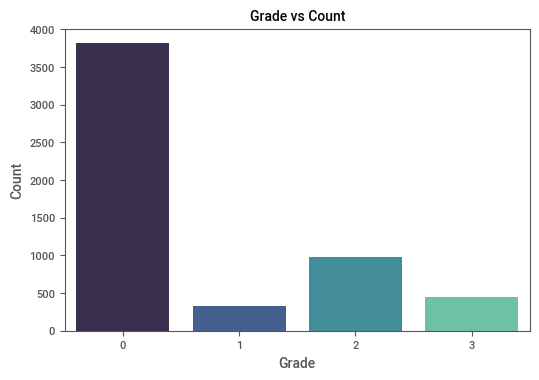

In [18]:
sns.countplot(df.Grade, palette='mako')
plt.title('Grade vs Count', size=10)
plt.xlabel('Grade', size=10)
plt.ylabel('Count', size=10)
plt.show()

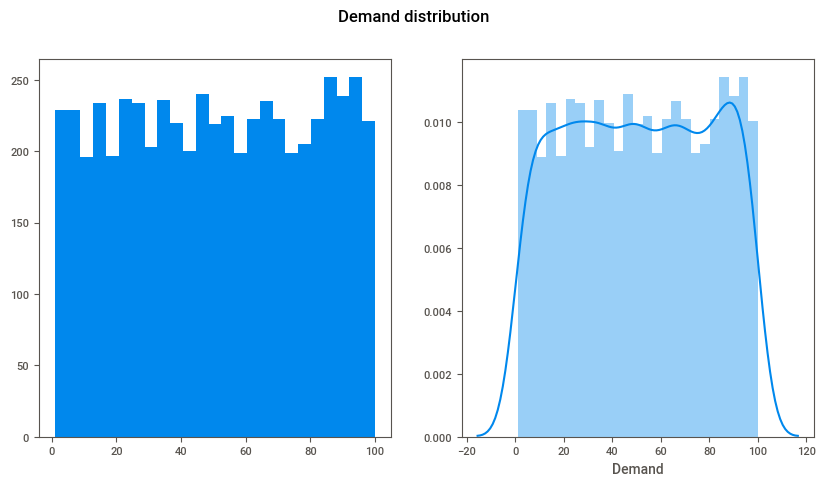

Demand spread out uniformly


In [19]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.distplot(df.Demand, ax=axs[1], bins=25)
# axs[0].set_title('Charges 1', size=10)
axs[0].hist(df.Demand, bins=25)
# axs[1].set_title('Charges 2 (%)', size=10)
fig.suptitle('Demand distribution')
plt.show()
print('Demand spread out uniformly')

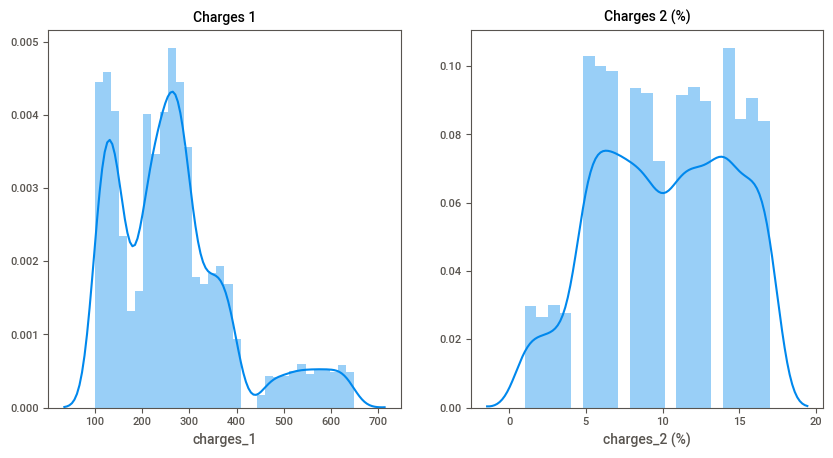

In [20]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.distplot(df.charges_1, ax=axs[0])
axs[0].set_title('Charges 1', size=10)
sns.distplot(df['charges_2 (%)'], ax=axs[1])
axs[1].set_title('Charges 2 (%)', size=10)
plt.show()

In [21]:
axs

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002528C4A8E88>,
      dtype=object)

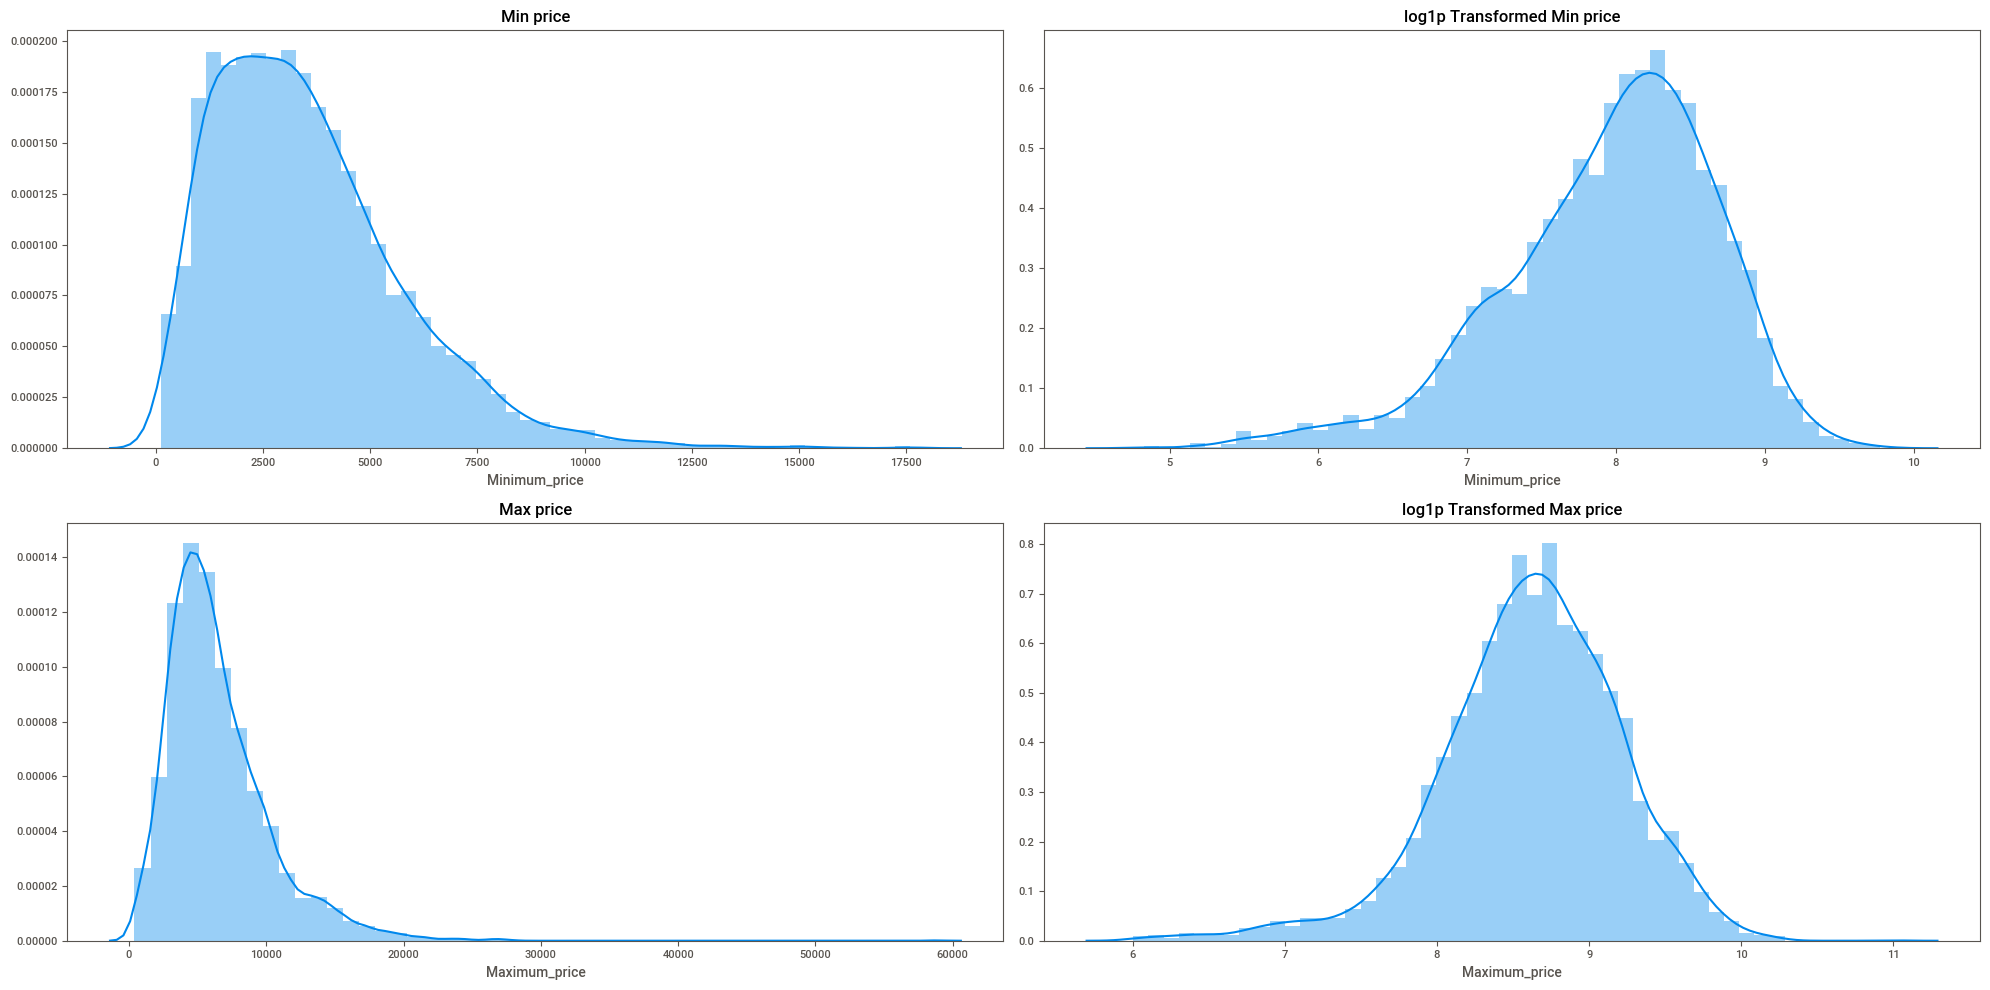

Prices before & after log Transformations
Log transformation helps centre skewed data


In [22]:
fig, axs = plt.subplots(2,2, figsize=(20,10))
sns.distplot(df.Minimum_price, ax=axs[0][0])
axs[0][0].set_title('Min price')
sns.distplot(np.log1p(df.Minimum_price), ax=axs[0][1])
axs[0][1].set_title('log1p Transformed Min price')

sns.distplot(df.Maximum_price, ax=axs[1][0])
axs[1][0].set_title('Max price')
sns.distplot(np.log1p(df.Maximum_price), ax=axs[1][1])
axs[1][1].set_title('log1p Transformed Max price')

plt.tight_layout()
plt.show()
print('Prices before & after log Transformations')
print('Log transformation helps centre skewed data')

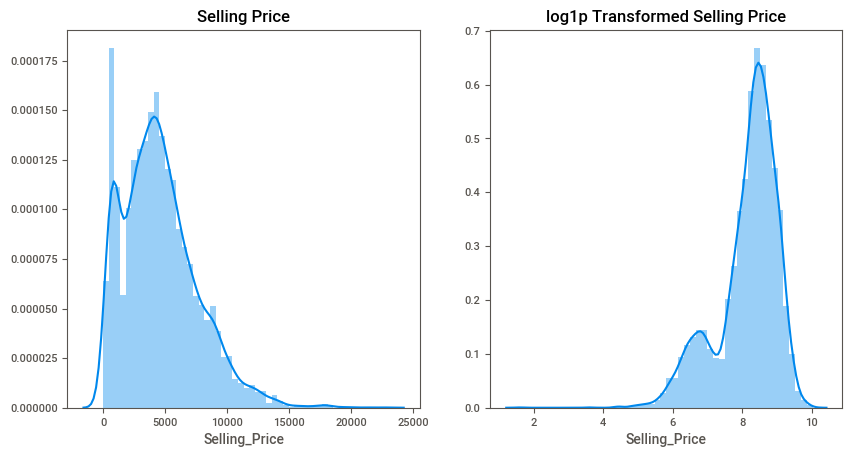

log Transformation of Selling_Price improves model predictions


In [23]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.distplot(df.Selling_Price, ax=axs[0])
axs[0].set_title('Selling Price')

sns.distplot(np.log1p(df.Selling_Price), ax=axs[1])
axs[1].set_title('log1p Transformed Selling Price')
plt.show()

print('log Transformation of Selling_Price improves model predictions')

Following plot shows Selling_Price outliers when grouped by Stall_no


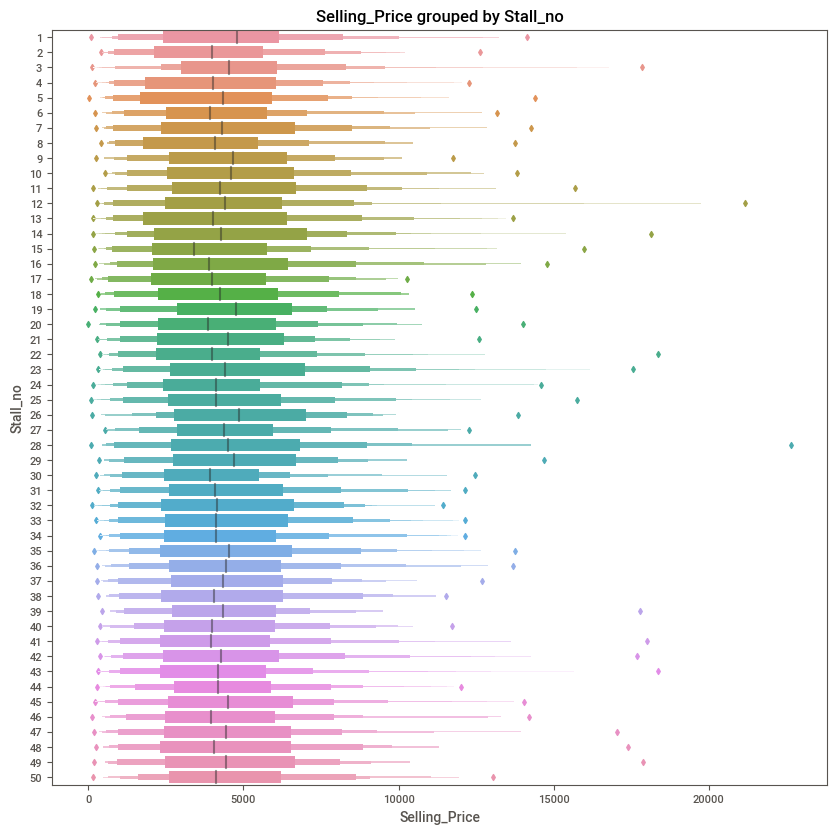

In [24]:
print('Following plot shows Selling_Price outliers when grouped by Stall_no')

fig, axs = plt.subplots(1,1, figsize=(10,10))
sns.boxenplot(x = "Selling_Price", y = "Stall_no",data = df, orient ="h", ax = axs) 
axs.set_title('Selling_Price grouped by Stall_no')
plt.show() 

Following plot shows Selling_Price outliers when grouped by Market_Category


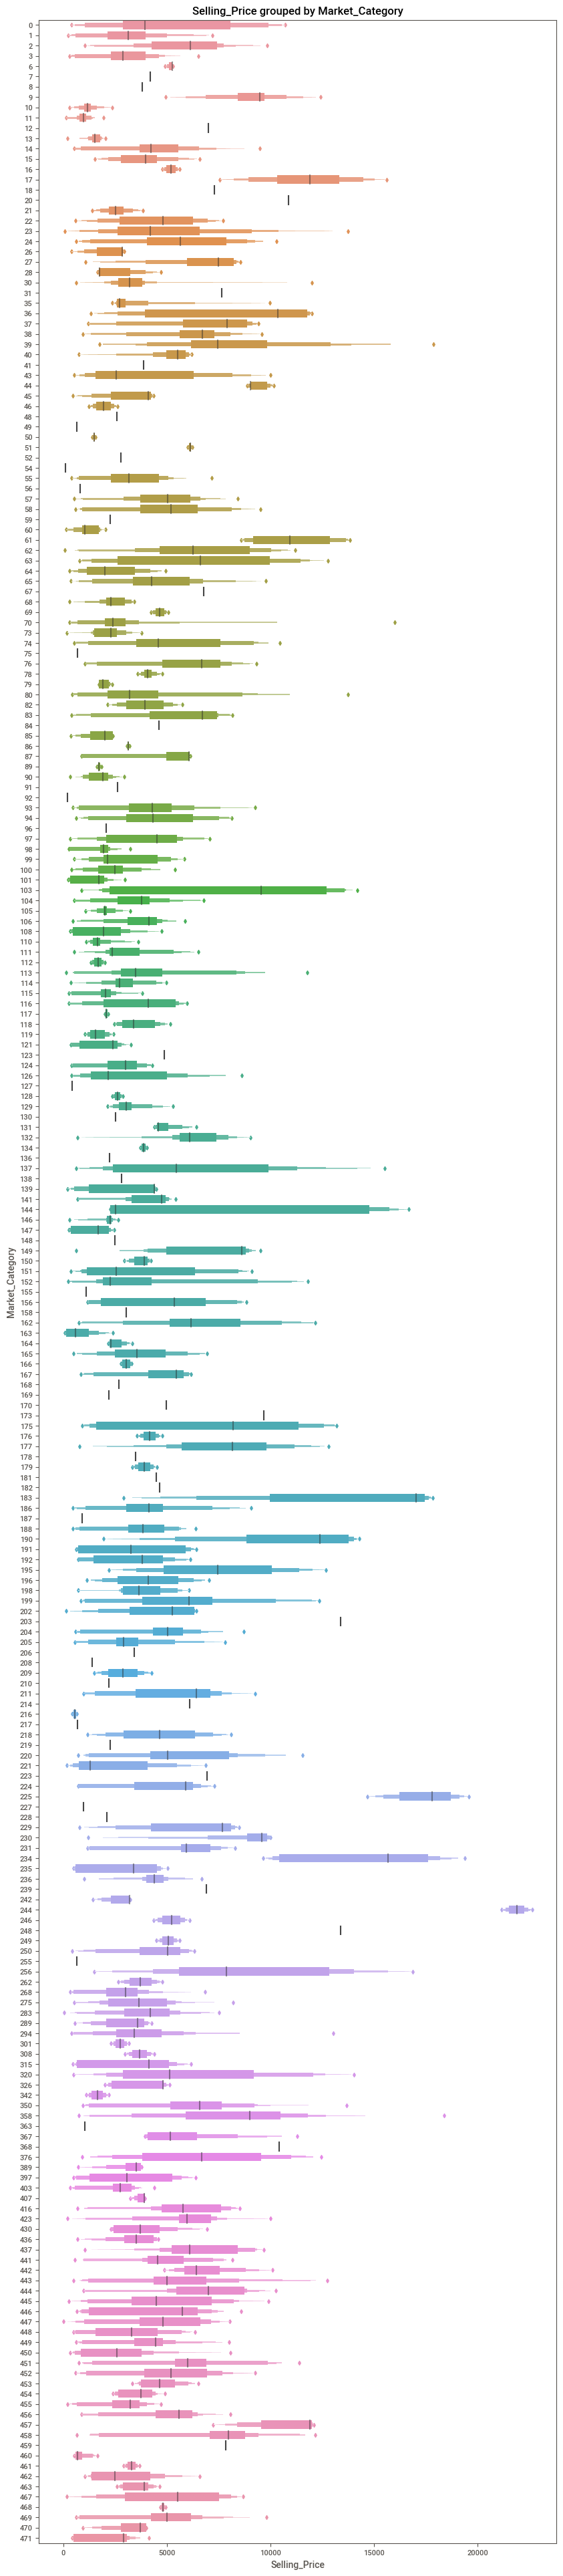

In [25]:
print('Following plot shows Selling_Price outliers when grouped by Market_Category')

fig, axs = plt.subplots(1,1, figsize=(10,50))
sns.boxenplot(x = "Selling_Price", y = "Market_Category",data = df, orient ="h", ax = axs) 
axs.set_title('Selling_Price grouped by Market_Category')
plt.show() 

Outlier Treatment

In [26]:
for ind, row in df.iterrows():
    x = row['Selling_Price']
    mean = df[df.Stall_no==row['Stall_no']].Selling_Price.mean()
    std = df[df.Stall_no==row['Stall_no']].Selling_Price.std()
    df.loc[ind, 'stall_z']= (x-mean)/std
    
    mean = df[df.Market_Category==row['Market_Category']].Selling_Price.mean()
    std = df[df.Market_Category==row['Market_Category']].Selling_Price.std()
    df.loc[ind, 'market_z']= (x-mean)/std

Added columns `stall_z` and `market_z` which show z value of Selling_Price when grouped by corresponding `Stall_no` and `Market_Category`  
Will be useful for dropping outliers

In [27]:
df.head()

,Product_id,Stall_no,instock_date,Market_Category,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price,stall_z,market_z
0,BRAE2NF6JA5GUEXG,37,2015-08-22 18:36:12.000,2,Yes,Fashion,1,68,0,376.0,11.0,2983.0,4713.0,4185.947700,-0.149704,-0.679554
1,TUNE8SFB6RJN2HSD,38,2016-03-27 21:19:13.000,24,Yes,Fashion,0,51,0,397.0,12.0,7495.0,10352.0,9271.490256,1.565966,1.342589
2,BRAEAR7WZPQGPBZU,9,2015-08-18 19:25:22.000,447,Yes,Child_care,0,10,0,250.0,9.0,5752.0,7309.0,6785.701362,0.771083,0.976414
3,WATDZ2ZQ8JPDHCTJ,50,2016-03-28 21:53:01.000,23,Yes,Educational,2,48,0,144.0,13.0,5090.0,20814.0,13028.917824,2.955904,2.682788
4,JWSEBUKYQPMBZ3RK,7,2016-03-29 22:58:53.000,63,Yes,Repair,1,35,1,211.0,4.0,2430.0,9261.0,906.553935,-1.198309,-1.424314


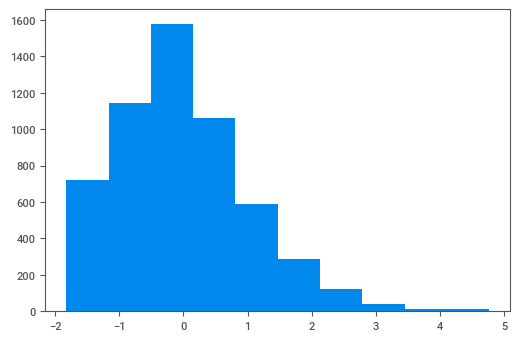

In [28]:
# sns.distplot(df.stall_z)
plt.hist(df.stall_z)
plt.show()

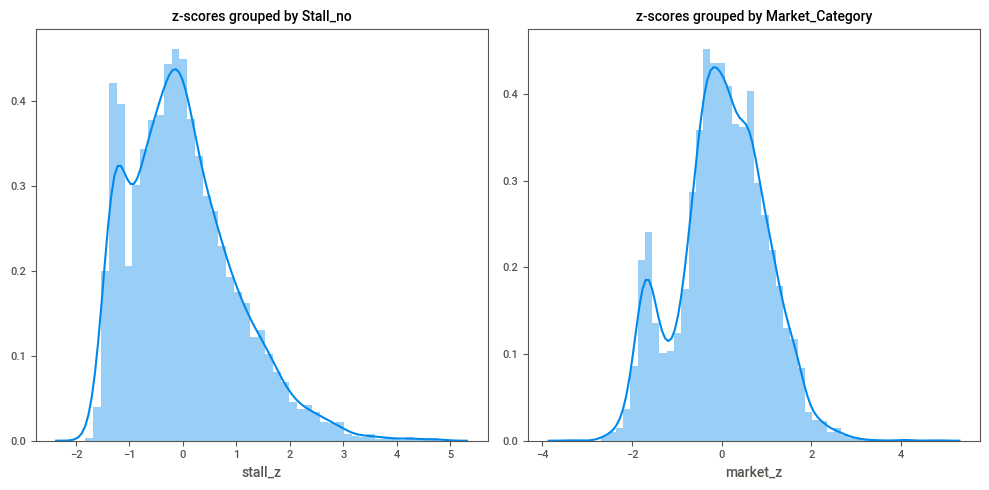

Multiple points have extreme z-scores
z-scores with abs value > 2 can be considered outliers


In [29]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

sns.distplot(df.stall_z, ax = axs[0])
axs[0].set_title("z-scores grouped by Stall_no", fontsize=10)

sns.distplot(df.market_z, ax = axs[1])
axs[1].set_title("z-scores grouped by Market_Category", fontsize=10)

plt.tight_layout()
plt.show()
print('Multiple points have extreme z-scores')
print('z-scores with abs value > 2 can be considered outliers')

Creating a copy of data for transformations

In [30]:
df1 = df.copy()
test_df1 = test_df.copy()

## Applying log Transformations
df1.Minimum_price = df1.Minimum_price.apply(np.log1p)
test_df1.Minimum_price = test_df1.Minimum_price.apply(np.log1p)
df1.Maximum_price = df1.Maximum_price.apply(np.log1p)
test_df1.Maximum_price= test_df1.Maximum_price.apply(np.log1p)
df1.Selling_Price = df1.Selling_Price.apply(np.log1p)

## Encoding Loyalty_customer as binary
df1.Loyalty_customer = df1.Loyalty_customer.apply(lambda x: 1 if x=='Yes' else 0)
test_df1.Loyalty_customer = test_df1.Loyalty_customer.apply(lambda x: 1 if x=='Yes' else 0)

In [31]:
df1

,Product_id,Stall_no,instock_date,Market_Category,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price,stall_z,market_z
0,BRAE2NF6JA5GUEXG,37,2015-08-22 18:36:12.000,2,1,Fashion,1,68,0,376.0,11.0,8.001020,8.458292,8.339727,-0.149704,-0.679554
1,TUNE8SFB6RJN2HSD,38,2016-03-27 21:19:13.000,24,1,Fashion,0,51,0,397.0,12.0,8.922125,9.245032,9.134807,1.565966,1.342589
2,BRAEAR7WZPQGPBZU,9,2015-08-18 19:25:22.000,447,1,Child_care,0,10,0,250.0,9.0,8.657477,8.896999,8.822720,0.771083,0.976414
3,WATDZ2ZQ8JPDHCTJ,50,2016-03-28 21:53:01.000,23,1,Educational,2,48,0,144.0,13.0,8.535230,9.943429,9.475003,2.955904,2.682788
4,JWSEBUKYQPMBZ3RK,7,2016-03-29 22:58:53.000,63,1,Repair,1,35,1,211.0,4.0,7.796058,9.133675,6.810753,-1.198309,-1.424314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6363,WATE7VE2D62VEKW8,17,2016-03-28 19:55:43.000,24,1,Technology,0,47,0,614.0,10.0,9.008836,9.329633,9.237812,2.275756,1.712850
6364,SHOEF9G8Z4ZXF6WE,21,2015-02-11 15:09:26.000,55,1,Child_care,0,35,0,269.0,5.0,8.178919,8.501267,8.412463,0.028947,0.808439
6365,PBXEB9ZQ7HHCFXYG,36,2015-11-19 17:29:21.000,358,0,Repair,3,29,0,283.0,3.0,8.576217,9.589804,9.232090,1.797926,0.541379
6366,NKCEAGXHRYTNTMG7,27,2015-12-08 04:19:33.000,452,1,Repair,0,8,0,267.0,3.0,8.374477,8.674197,8.586811,0.220115,0.129689


In [32]:
df1 = df1.sample(frac=1)
df1.drop(['Product_id','instock_date'], axis=1, inplace=True)
test_df1.drop(['Product_id','instock_date'], axis=1, inplace=True)
train_X, valid_X, train_y, valid_y = train_test_split(df1.drop('Selling_Price', axis=1), df1[['Selling_Price']], test_size=0.1)

In [33]:
df1.reset_index(drop=True,inplace=True)
filter_1=df1[abs(df1.stall_z)>2.3].index
df1.drop(filter_1, inplace=True)
df1.reset_index(drop=True,inplace=True)
filter_2=df1[abs(df1.market_z)>2.3].index
df1.drop(filter_2, inplace=True)
df1.reset_index(drop=True,inplace=True)

print(f'Dropped {filter_1.shape[0] + filter_2.shape[0]} rows as outliers')

Dropped 181 rows as outliers


In [34]:
df1 = df1.drop(['market_z', 'stall_z'],axis=1)
train_X, valid_X, train_y, valid_y = train_test_split(df1.drop('Selling_Price', axis=1), df1[['Selling_Price']], test_size=0.1)

In [35]:
df1

,Stall_no,Market_Category,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price
0,40,55,0,Educational,0,26,0,127.0,12.0,7.059618,8.110127,7.770541
1,15,23,1,Technology,1,85,1,484.0,8.0,8.013012,8.705497,6.609836
2,31,451,0,Pet_care,0,75,0,149.0,3.0,8.700847,8.918249,8.827563
3,29,460,0,Technology,3,93,0,559.0,9.0,5.638355,6.171701,6.830688
4,33,211,0,Cosmetics,0,7,0,289.0,16.0,7.842671,8.409608,8.246106
...,...,...,...,...,...,...,...,...,...,...,...,...
5384,6,152,1,Technology,0,47,0,623.0,11.0,7.625107,7.952967,8.023727
5385,18,24,1,Organic,0,31,1,108.0,8.0,8.305484,8.591744,6.583797
5386,32,3,1,Home_decor,0,64,0,251.0,12.0,8.201112,8.553332,8.439037
5387,41,70,1,Technology,2,39,0,558.0,17.0,7.390799,8.397959,8.184143


In [36]:
def rmsle(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y

    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

Best Parameters obtained by gridsearchcv below

In [37]:
best_params ={'score_function': 'Cosine',
              'loss_function': 'RMSE',
              'l2_leaf_reg': 5,
              'feature_border_type': 'MinEntropy',
              'depth': 6}

In [38]:
train_X

,Stall_no,Market_Category,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price
4865,3,131,1,Educational,0,46,0,172.0,5.0,7.800982,8.764053
3362,5,443,1,Home_decor,0,38,0,201.0,16.0,8.392763,8.819518
2802,35,24,1,Child_care,0,70,0,298.0,6.0,8.065894,8.382747
2100,5,350,1,Child_care,1,60,1,257.0,8.0,8.439448,8.960468
3485,4,149,1,Pet_care,0,53,0,120.0,1.0,8.830689,9.194719
...,...,...,...,...,...,...,...,...,...,...,...
4334,14,63,1,Organic,1,55,1,115.0,5.0,8.537388,9.549666
4249,7,437,0,Educational,0,36,0,128.0,6.0,8.914626,9.278746
2785,12,452,1,Hospitality,0,44,1,337.0,9.0,8.806424,9.056140
4212,32,3,0,Child_care,0,14,0,293.0,10.0,8.173293,8.529517


In [39]:
model = CatBoostRegressor(iterations = 1000, **best_params, cat_features=['Stall_no', 'Market_Category', 'Loyalty_customer', 'Product_Category'])

model.fit(train_X, train_y, eval_set=[(valid_X, valid_y)], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8257843	test: 0.8466802	best: 0.8466802 (0)	total: 90.8ms	remaining: 1m 30s
1:	learn: 0.8050536	test: 0.8249972	best: 0.8249972 (1)	total: 114ms	remaining: 57s
2:	learn: 0.7854551	test: 0.8048709	best: 0.8048709 (2)	total: 140ms	remaining: 46.6s
3:	learn: 0.7653973	test: 0.7842994	best: 0.7842994 (3)	total: 174ms	remaining: 43.4s
4:	learn: 0.7467373	test: 0.7647476	best: 0.7647476 (4)	total: 206ms	remaining: 41s
5:	learn: 0.7276982	test: 0.7450404	best: 0.7450404 (5)	total: 220ms	remaining: 36.5s
6:	learn: 0.7100756	test: 0.7271336	best: 0.7271336 (6)	total: 246ms	remaining: 34.9s
7:	learn: 0.6919708	test: 0.7084796	best: 0.7084796 (7)	total: 274ms	remaining: 34s
8:	learn: 0.6753410	test: 0.6916440	best: 0.6916440 (8)	total: 291ms	remaining: 32s
9:	learn: 0.6580846	test: 0.6737510	best: 0.6737510 (9)	total: 321ms	remaining: 31.8s
10:	learn: 0.6411830	test: 0.6566165	best: 0.6566165 (10)	total: 346ms	remaining: 31.1s
11:	learn: 0.6256051	test: 0.6404624	best: 0.6404624 (11)	

100:	learn: 0.1461835	test: 0.0968821	best: 0.0968821 (100)	total: 2.72s	remaining: 24.2s
101:	learn: 0.1454181	test: 0.0954392	best: 0.0954392 (101)	total: 2.74s	remaining: 24.1s
102:	learn: 0.1444605	test: 0.0940184	best: 0.0940184 (102)	total: 2.76s	remaining: 24s
103:	learn: 0.1437581	test: 0.0926590	best: 0.0926590 (103)	total: 2.78s	remaining: 24s
104:	learn: 0.1430785	test: 0.0913304	best: 0.0913304 (104)	total: 2.8s	remaining: 23.9s
105:	learn: 0.1421935	test: 0.0899507	best: 0.0899507 (105)	total: 2.83s	remaining: 23.9s
106:	learn: 0.1414779	test: 0.0885693	best: 0.0885693 (106)	total: 2.86s	remaining: 23.9s
107:	learn: 0.1409226	test: 0.0875006	best: 0.0875006 (107)	total: 2.88s	remaining: 23.8s
108:	learn: 0.1404356	test: 0.0864769	best: 0.0864769 (108)	total: 2.9s	remaining: 23.7s
109:	learn: 0.1398782	test: 0.0853428	best: 0.0853428 (109)	total: 2.93s	remaining: 23.7s
110:	learn: 0.1393551	test: 0.0841466	best: 0.0841466 (110)	total: 2.94s	remaining: 23.6s
111:	learn: 0.13

197:	learn: 0.1229510	test: 0.0420974	best: 0.0420974 (197)	total: 5.44s	remaining: 22s
198:	learn: 0.1225603	test: 0.0419111	best: 0.0419111 (198)	total: 5.46s	remaining: 22s
199:	learn: 0.1225043	test: 0.0416832	best: 0.0416832 (199)	total: 5.47s	remaining: 21.9s
200:	learn: 0.1224646	test: 0.0415215	best: 0.0415215 (200)	total: 5.5s	remaining: 21.9s
201:	learn: 0.1223910	test: 0.0413636	best: 0.0413636 (201)	total: 5.52s	remaining: 21.8s
202:	learn: 0.1221304	test: 0.0413548	best: 0.0413548 (202)	total: 5.54s	remaining: 21.8s
203:	learn: 0.1220774	test: 0.0410859	best: 0.0410859 (203)	total: 5.57s	remaining: 21.7s
204:	learn: 0.1220681	test: 0.0410742	best: 0.0410742 (204)	total: 5.58s	remaining: 21.6s
205:	learn: 0.1220411	test: 0.0409670	best: 0.0409670 (205)	total: 5.59s	remaining: 21.5s
206:	learn: 0.1220179	test: 0.0409307	best: 0.0409307 (206)	total: 5.61s	remaining: 21.5s
207:	learn: 0.1219875	test: 0.0407091	best: 0.0407091 (207)	total: 5.62s	remaining: 21.4s
208:	learn: 0.1

289:	learn: 0.1168573	test: 0.0357185	best: 0.0357185 (289)	total: 7.63s	remaining: 18.7s
290:	learn: 0.1167179	test: 0.0357071	best: 0.0357071 (290)	total: 7.64s	remaining: 18.6s
291:	learn: 0.1167155	test: 0.0357136	best: 0.0357071 (290)	total: 7.65s	remaining: 18.6s
292:	learn: 0.1166862	test: 0.0355679	best: 0.0355679 (292)	total: 7.68s	remaining: 18.5s
293:	learn: 0.1166735	test: 0.0354695	best: 0.0354695 (293)	total: 7.71s	remaining: 18.5s
294:	learn: 0.1166219	test: 0.0354542	best: 0.0354542 (294)	total: 7.73s	remaining: 18.5s
295:	learn: 0.1164455	test: 0.0354370	best: 0.0354370 (295)	total: 7.76s	remaining: 18.4s
296:	learn: 0.1164369	test: 0.0354330	best: 0.0354330 (296)	total: 7.78s	remaining: 18.4s
297:	learn: 0.1163963	test: 0.0352395	best: 0.0352395 (297)	total: 7.8s	remaining: 18.4s
298:	learn: 0.1163947	test: 0.0352447	best: 0.0352395 (297)	total: 7.82s	remaining: 18.3s
299:	learn: 0.1163752	test: 0.0351122	best: 0.0351122 (299)	total: 7.85s	remaining: 18.3s
300:	learn:

382:	learn: 0.1126759	test: 0.0330217	best: 0.0330089 (379)	total: 9.69s	remaining: 15.6s
383:	learn: 0.1126444	test: 0.0328538	best: 0.0328538 (383)	total: 9.71s	remaining: 15.6s
384:	learn: 0.1126441	test: 0.0328563	best: 0.0328538 (383)	total: 9.71s	remaining: 15.5s
385:	learn: 0.1126262	test: 0.0328064	best: 0.0328064 (385)	total: 9.74s	remaining: 15.5s
386:	learn: 0.1126258	test: 0.0328098	best: 0.0328064 (385)	total: 9.75s	remaining: 15.4s
387:	learn: 0.1125966	test: 0.0326927	best: 0.0326927 (387)	total: 9.77s	remaining: 15.4s
388:	learn: 0.1125650	test: 0.0325906	best: 0.0325906 (388)	total: 9.8s	remaining: 15.4s
389:	learn: 0.1125647	test: 0.0325943	best: 0.0325906 (388)	total: 9.81s	remaining: 15.3s
390:	learn: 0.1125324	test: 0.0326127	best: 0.0325906 (388)	total: 9.83s	remaining: 15.3s
391:	learn: 0.1122806	test: 0.0325512	best: 0.0325512 (391)	total: 9.85s	remaining: 15.3s
392:	learn: 0.1122693	test: 0.0325555	best: 0.0325512 (391)	total: 9.86s	remaining: 15.2s
393:	learn:

481:	learn: 0.1094451	test: 0.0324625	best: 0.0322444 (431)	total: 11.3s	remaining: 12.1s
482:	learn: 0.1094258	test: 0.0325241	best: 0.0322444 (431)	total: 11.3s	remaining: 12.1s
483:	learn: 0.1094219	test: 0.0325416	best: 0.0322444 (431)	total: 11.3s	remaining: 12s
484:	learn: 0.1093975	test: 0.0324577	best: 0.0322444 (431)	total: 11.3s	remaining: 12s
485:	learn: 0.1093973	test: 0.0324595	best: 0.0322444 (431)	total: 11.3s	remaining: 12s
486:	learn: 0.1093700	test: 0.0324701	best: 0.0322444 (431)	total: 11.3s	remaining: 11.9s
487:	learn: 0.1091686	test: 0.0324813	best: 0.0322444 (431)	total: 11.4s	remaining: 11.9s
488:	learn: 0.1091420	test: 0.0324928	best: 0.0322444 (431)	total: 11.4s	remaining: 11.9s
489:	learn: 0.1090086	test: 0.0324704	best: 0.0322444 (431)	total: 11.4s	remaining: 11.9s
490:	learn: 0.1089590	test: 0.0324561	best: 0.0322444 (431)	total: 11.4s	remaining: 11.8s
491:	learn: 0.1089406	test: 0.0325078	best: 0.0322444 (431)	total: 11.4s	remaining: 11.8s
492:	learn: 0.10

574:	learn: 0.1040152	test: 0.0338401	best: 0.0322444 (431)	total: 13.4s	remaining: 9.92s
575:	learn: 0.1039948	test: 0.0337793	best: 0.0322444 (431)	total: 13.5s	remaining: 9.91s
576:	learn: 0.1039948	test: 0.0337808	best: 0.0322444 (431)	total: 13.5s	remaining: 9.87s
577:	learn: 0.1036985	test: 0.0337732	best: 0.0322444 (431)	total: 13.5s	remaining: 9.84s
578:	learn: 0.1036825	test: 0.0337944	best: 0.0322444 (431)	total: 13.5s	remaining: 9.81s
579:	learn: 0.1036824	test: 0.0337956	best: 0.0322444 (431)	total: 13.5s	remaining: 9.77s
580:	learn: 0.1036823	test: 0.0337967	best: 0.0322444 (431)	total: 13.5s	remaining: 9.74s
581:	learn: 0.1036820	test: 0.0337952	best: 0.0322444 (431)	total: 13.5s	remaining: 9.71s
582:	learn: 0.1036820	test: 0.0337955	best: 0.0322444 (431)	total: 13.5s	remaining: 9.68s
583:	learn: 0.1036661	test: 0.0338750	best: 0.0322444 (431)	total: 13.5s	remaining: 9.65s
584:	learn: 0.1034646	test: 0.0338522	best: 0.0322444 (431)	total: 13.6s	remaining: 9.62s
585:	learn

669:	learn: 0.1011069	test: 0.0361221	best: 0.0322444 (431)	total: 15.1s	remaining: 7.45s
670:	learn: 0.1011068	test: 0.0361206	best: 0.0322444 (431)	total: 15.1s	remaining: 7.42s
671:	learn: 0.1011066	test: 0.0361191	best: 0.0322444 (431)	total: 15.1s	remaining: 7.39s
672:	learn: 0.1010961	test: 0.0361880	best: 0.0322444 (431)	total: 15.2s	remaining: 7.36s
673:	learn: 0.1010960	test: 0.0361898	best: 0.0322444 (431)	total: 15.2s	remaining: 7.34s
674:	learn: 0.1008986	test: 0.0361599	best: 0.0322444 (431)	total: 15.7s	remaining: 7.56s
675:	learn: 0.1006016	test: 0.0360986	best: 0.0322444 (431)	total: 15.7s	remaining: 7.54s
676:	learn: 0.1005940	test: 0.0361112	best: 0.0322444 (431)	total: 15.7s	remaining: 7.5s
677:	learn: 0.1005838	test: 0.0361798	best: 0.0322444 (431)	total: 15.7s	remaining: 7.47s
678:	learn: 0.1002894	test: 0.0361298	best: 0.0322444 (431)	total: 15.8s	remaining: 7.45s
679:	learn: 0.1002733	test: 0.0361545	best: 0.0322444 (431)	total: 15.8s	remaining: 7.43s
680:	learn:

763:	learn: 0.0975140	test: 0.0375132	best: 0.0322444 (431)	total: 17.3s	remaining: 5.34s
764:	learn: 0.0975139	test: 0.0375142	best: 0.0322444 (431)	total: 17.3s	remaining: 5.32s
765:	learn: 0.0975139	test: 0.0375152	best: 0.0322444 (431)	total: 17.3s	remaining: 5.29s
766:	learn: 0.0974820	test: 0.0374922	best: 0.0322444 (431)	total: 17.3s	remaining: 5.27s
767:	learn: 0.0974820	test: 0.0374924	best: 0.0322444 (431)	total: 17.4s	remaining: 5.24s
768:	learn: 0.0973323	test: 0.0374806	best: 0.0322444 (431)	total: 17.4s	remaining: 5.23s
769:	learn: 0.0973321	test: 0.0374816	best: 0.0322444 (431)	total: 17.4s	remaining: 5.2s
770:	learn: 0.0973156	test: 0.0374128	best: 0.0322444 (431)	total: 17.5s	remaining: 5.19s
771:	learn: 0.0973106	test: 0.0374889	best: 0.0322444 (431)	total: 17.5s	remaining: 5.16s
772:	learn: 0.0973106	test: 0.0374892	best: 0.0322444 (431)	total: 17.5s	remaining: 5.14s
773:	learn: 0.0973057	test: 0.0375649	best: 0.0322444 (431)	total: 17.5s	remaining: 5.11s
774:	learn:

860:	learn: 0.0943021	test: 0.0399397	best: 0.0322444 (431)	total: 19.6s	remaining: 3.17s
861:	learn: 0.0942415	test: 0.0398978	best: 0.0322444 (431)	total: 19.7s	remaining: 3.15s
862:	learn: 0.0942099	test: 0.0398963	best: 0.0322444 (431)	total: 19.7s	remaining: 3.13s
863:	learn: 0.0942073	test: 0.0399598	best: 0.0322444 (431)	total: 19.7s	remaining: 3.11s
864:	learn: 0.0942048	test: 0.0400228	best: 0.0322444 (431)	total: 19.8s	remaining: 3.08s
865:	learn: 0.0941759	test: 0.0400195	best: 0.0322444 (431)	total: 19.8s	remaining: 3.06s
866:	learn: 0.0941735	test: 0.0400816	best: 0.0322444 (431)	total: 19.8s	remaining: 3.04s
867:	learn: 0.0939062	test: 0.0400640	best: 0.0322444 (431)	total: 19.8s	remaining: 3.02s
868:	learn: 0.0938829	test: 0.0400601	best: 0.0322444 (431)	total: 19.9s	remaining: 3s
869:	learn: 0.0938384	test: 0.0400542	best: 0.0322444 (431)	total: 19.9s	remaining: 2.98s
870:	learn: 0.0938170	test: 0.0400562	best: 0.0322444 (431)	total: 19.9s	remaining: 2.95s
871:	learn: 0

955:	learn: 0.0901615	test: 0.0419158	best: 0.0322444 (431)	total: 22.2s	remaining: 1.02s
956:	learn: 0.0901507	test: 0.0419824	best: 0.0322444 (431)	total: 22.2s	remaining: 998ms
957:	learn: 0.0901496	test: 0.0420253	best: 0.0322444 (431)	total: 22.2s	remaining: 974ms
958:	learn: 0.0901460	test: 0.0420545	best: 0.0322444 (431)	total: 22.2s	remaining: 950ms
959:	learn: 0.0901405	test: 0.0421047	best: 0.0322444 (431)	total: 22.2s	remaining: 926ms
960:	learn: 0.0901139	test: 0.0421018	best: 0.0322444 (431)	total: 22.3s	remaining: 904ms
961:	learn: 0.0898653	test: 0.0420880	best: 0.0322444 (431)	total: 22.3s	remaining: 882ms
962:	learn: 0.0898600	test: 0.0421377	best: 0.0322444 (431)	total: 22.4s	remaining: 862ms
963:	learn: 0.0898209	test: 0.0421383	best: 0.0322444 (431)	total: 22.5s	remaining: 841ms
964:	learn: 0.0898200	test: 0.0421365	best: 0.0322444 (431)	total: 22.5s	remaining: 818ms
965:	learn: 0.0895739	test: 0.0421390	best: 0.0322444 (431)	total: 22.6s	remaining: 795ms
966:	learn

In [40]:
pred = model.predict(test_df1)
pred = np.expm1(pred) ## Reverse log transformation

Create Submission File

In [41]:
submission=test_df[['Product_id']]
submission['Selling_Price'] = 0
submission.loc[:, 'Selling_Price'] = pred
submission.Selling_Price = submission.Selling_Price.apply(abs)
submission.to_csv('submission.csv', index=False)

C:\Users\mazha\anaconda3\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mazha\anaconda3\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\mazha\anaconda3\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [42]:
importance = [round(i,3) for i in model.feature_importances_]

In [43]:
columns= ['Stall_no','Market_Category',
            'Loyalty_customer', 'Product_Category',
            'Grade', 'Demand',
            'Discount_avail', 'charges_1',
            'charges_2 (%)',
           'Minimum_price', 'Maximum_price']

In [44]:
col_imp = list(zip(columns, importance))
col_imp

[('Stall_no', 0.093),
 ('Market_Category', 0.026),
 ('Loyalty_customer', 0.017),
 ('Product_Category', 0.142),
 ('Grade', 0.546),
 ('Demand', 0.124),
 ('Discount_avail', 74.881),
 ('charges_1', 0.38),
 ('charges_2 (%)', 0.108),
 ('Minimum_price', 6.09),
 ('Maximum_price', 17.591)]

Can do barplot visualization about feature importance 